## ExMAS
> Equilibrium matching


In [1]:
import os
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
cwd = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
pd.options.display.max_columns = None

In [9]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData as inData
from ExMAS.main import matching
from ExMAS.extras import games, pricings, prunings, pipeline

In [10]:
params = ExMAS.utils.get_config('ExMAS/spinoffs/game/pipe.json') # load the default 
params.t0 = pd.to_datetime(params.t0)
params.matching_obj = 'u_pax'
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
params.nP = 150
params.simTime = 0.2
params.shared_discount = 0.3
inData = ExMAS.utils.generate_demand(inData, params)  # generate requests

In [11]:
from ExMAS.main import init_log
params.logger_level = 'WARNING'
inData.logger = init_log(params)

In [12]:
inData = ExMAS.main(inData, params, plot = False)
KPIs = inData.sblts.res.to_frame('u_pax')
inData = games.prepare_PoA(inData)  # prepare data structures

0
1
2
3
4
5
6


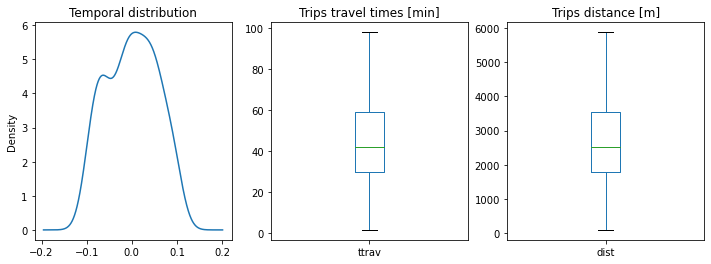

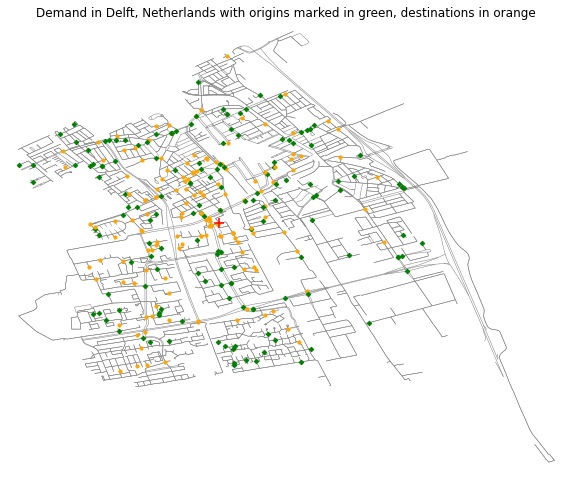

In [13]:
ExMAS.utils.plot_demand(inData, params)

### incidence matrix
rows are trips columns are rides,
1 if trip blongs to a ride, 0 otherwise

### parameters

eq. 1 , eq.2

In [14]:

params.time_cost = params.VoT # travellers' cost per travel time
params.wait_cost = params.time_cost*1.5 # and waiting
params.sharing_penalty_fixed = 0 # fixed penalty (EUR) per 
params.sharing_penalty_multiplier = 0.2 # fixed penalty (EUR) per 

params.veh_cost = 1.3*params.VoT/params.avg_speed # operating costs per kilometer
params.fixed_ride_cost = 0.5 # ride fixed costs (per vehicle)

In [10]:
inData = games.prepare_PoA(inData)

In [18]:
inData.sblts.rides_multi_index.loc[rs,:]

ride  traveller  shared  degree  treq ride_time  dist  ttrav  \
662  39    662         39    True       2   212       886  3555    444   
     75    662         75    True       2   357       886  4142    517   
917  28    917         28    True       2   168       529  3370    421   
     92    917         92    True       2   433       529   879    109   
1411 53   1411         53    True       3   265       949  3179    397   
     32   1411         32    True       3   187       949  4319    539   
     81   1411         81    True       3   390       949  4346    543   
1839 69   1839         69    True       4   345      1040  5883    735   
     107  1839        107    True       4   496      1040  3284    410   
     117  1839        117    True       4   583      1040  3145    393   
     141  1839        141    True       4   684      1040  1711    213   

          ttrav_sh  delay distance cost_veh  cost_user  total_group_cost  \
662  39        518  -67.0     7088   4.5313   2.527350          9.912550   
     75        577   82.0     7088   4.5313   2.853900          9.912550   
917  28        514  -34.5     4232  2.90695   2.339925          6.199750   
     92        165   49.5     4232  2.90695   0.952875          6.199750   
1411 53        489  -96.5     7592  4.81795   2.560425         14.907925   
     32        819  111.5     7592  4.81795   4.025175         14.907925   
     81        775  -47.5     7592  4.81795   3.504375         14.907925   
1839 69       1040   58.0     8320    5.232   4.672500         20.026500   
     107       637  -43.0     8320    5.232   2.901150         20.026500   
     117       652  208.0     8320    5.232   3.830400         20.026500   
     141       566  193.0     8320    5.232   3.390450         20.026500   

          cost_single  total_singles  residual_user   UNIFORM  EXTERNALITY  \
662  39       4.07420        8.73605       1.176500  4.956275     5.250700   
     75       4.66185        8.73605       1.176500  4.956275     5.838350   
917  28       3.88905        5.26650       0.933250  3.099875     4.822300   
     92       1.37745        5.26650       0.933250  3.099875     2.310700   
1411 53       3.69585       13.40595       1.501975  4.969308     4.496275   
     32       4.83895       13.40595       1.501975  4.969308     6.914425   
     81       4.87115       13.40595       1.501975  4.969308     5.481175   
1839 69       6.41675       16.09555       3.930950  5.006625     8.418900   
     107      3.80050       16.09555       3.930950  5.006625         -inf   
     117      3.66365       16.09555       3.930950  5.006625         -inf   
     141      2.21465       16.09555       3.930950  5.006625     3.709300   

          RESIDUAL  SUBGROUP  
662  39   4.626753   4.07420  
     75   5.285797   4.66185  
917  28   4.552235   3.88905  
     92   1.647515   1.37745  
1411 53   4.076990   3.69585  
     32   5.438130   4.83895  
     81   5.392805   4.87115  
1839 69   7.658249   6.41675  
     107  4.571346   3.80050  
     117  4.681401   3.66365  
     141  3.115504   2.21465

In [50]:
plt.style.use(['science'])
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



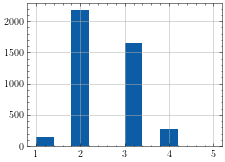

In [28]:
inData.sblts.rides_multi_index.degree.hist()

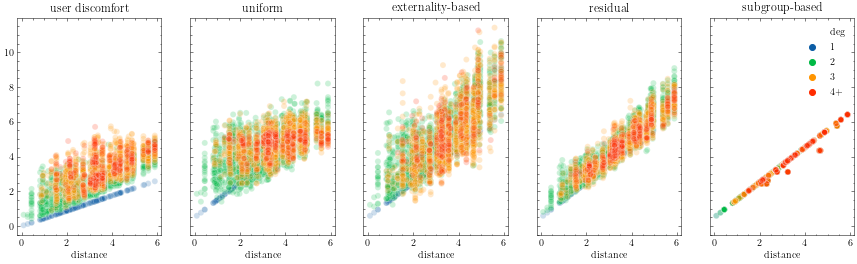

In [74]:
palette = sns.color_palette(colors[0:4])
df['travel time'] = df['ttrav_sh']
df['user discomfort'] = df['cost_user']
cols = ['user discomfort','UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']
titles = ['user discomfort','uniform', 'externality-based','residual','subgroup-based']

fig, axes = plt.subplots(1,len(cols), figsize = (len(cols)*3,4), sharey=True)
df = inData.sblts.rides_multi_index
df['deg'] = df.degree.apply(lambda x: '4+' if x>3 else str(x))
df['distance'] = df['dist']/1000

for i,col in enumerate(cols):
    
    
    axes[i].set_title(titles[i])
    sns.scatterplot(x='distance',y=col, data = df, ax = axes[i], hue = 'deg', alpha = 0.2, palette = palette)
    axes[i].set_ylabel('')
    if i<len(cols)-1:
        axes[i].get_legend().remove()
plf.savefig('f3.png')
plt.tight_layout() 
plt.savefig('res_1.tiff', dpi = 600)
plt.savefig('res_1.jpg', dpi = 600)
plt.savefig('res_1.pdf', rasterized = True)

### pricings with various strategies

ValueError: Axis limits cannot be NaN or Inf

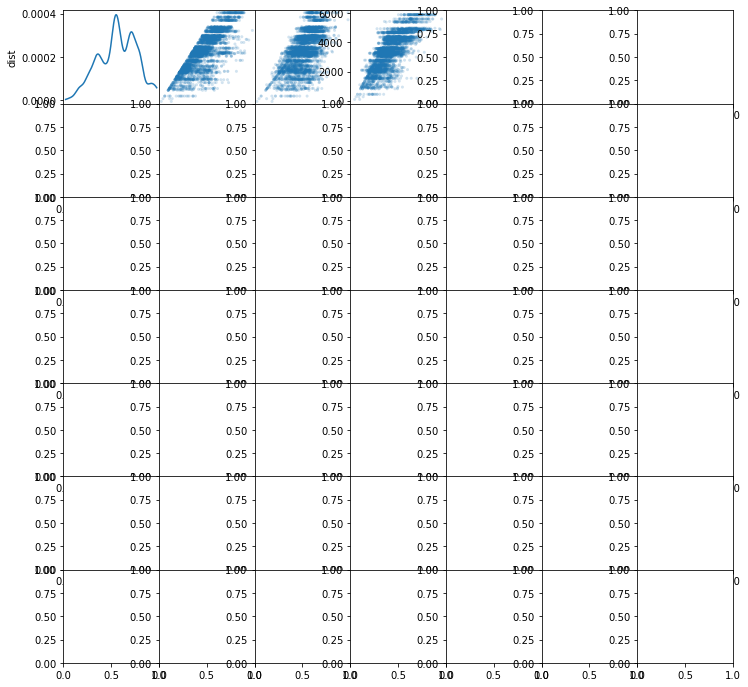

In [16]:
inData = ExMAS.extras.pricings.update_costs(inData, params)
inData = pricings.uniform_split(inData) 
inData = pricings.externality_split(inData) 
inData = pricings.residual_split(inData) 
inData = pricings.subgroup_split_bas(inData) 
rs = inData.sblts.rides.sample(4).index
plt.rcParams['figure.figsize'] = [12,12]
fig, ax = plt.subplots()
scatter_matrix(inData.sblts.rides_multi_index[['dist', 'ttrav_sh', 'UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP', 'total_group_cost']], grid = False, diagonal = 'kde', alpha = 0.2, ax = ax)
fig.suptitle('correlations between various prices and features')
inData.sblts.rides_multi_index.loc[rs,:]

# Differences between algorithms and pricings

## TNE

In [12]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_TNE, PRICING = PRICING, ALGO = 'TNE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:10-WARNING-Pruned nRides 51/222
15-12-20 16:21:10-WARNING-UNIFORM-TNE-UNIFORM-min
15-12-20 16:21:11-INFO-Matching 50 trips to 222 rides in order to min UNIFORM
15-12-20 16:21:11-INFO-Problem solution: Optimal. 
Total costs for single trips:            162 
reduced by matching to:                  159
15-12-20 16:21:11-INFO-DotMap(VehHourTrav=15108, VehHourTrav_ns=17058, PassHourTrav=17711, PassHourTrav_ns=17058, PassUtility=253.51685, PassUtility_ns=264.633, mean_lambda=0.30019524894240157, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=36, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.28, fleet_size_nonshared=45.0, fleet_size_shared=38.0, lambda_shared=0.30019524894240157)
15-12-20 16:21:11-WARNING-Pruned nRides 61/222
15-12-20 16:21:11-WARNING-EXTERNALITY-TNE-EXTERNALITY-min
15-12-20 16:21:12-INFO-Matching 50 trips to 222 rides in order to min EXTERNALITY
15-12-20 16:21:12-INFO-Problem solution

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15815,19702,0.76,88.755,100.877,31,162.314


## Hermetic

In [13]:
ret = dict()
params.logger_level = 'WARNING'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_HERMETIC, PRICING = PRICING, ALGO = 'HERMETIC', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:15-WARNING-Pruned nRides 51/222
15-12-20 16:21:15-WARNING-UNIFORM-HERMETIC-UNIFORM-min
15-12-20 16:21:16-WARNING-Pruned nRides 58/222
15-12-20 16:21:16-WARNING-EXTERNALITY-HERMETIC-EXTERNALITY-min
15-12-20 16:21:17-WARNING-Pruned nRides 58/222
15-12-20 16:21:17-WARNING-RESIDUAL-HERMETIC-RESIDUAL-min
15-12-20 16:21:20-WARNING-Pruned nRides 222/222
15-12-20 16:21:20-WARNING-SUBGROUP-HERMETIC-SUBGROUP-min


,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15815,19702,0.76,88.755,100.877,31,162.314


## RUE

In [14]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_RUE, PRICING = PRICING, ALGO = 'RUE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:21-INFO-Mergeable groups: 25-30
15-12-20 16:21:22-INFO-Mergeable groups: 5-88
15-12-20 16:21:22-INFO-Mergeable groups: 47-148
15-12-20 16:21:22-WARNING-Pruned nRides 222/222
15-12-20 16:21:22-WARNING-UNIFORM-RUE-UNIFORM-min
15-12-20 16:21:22-INFO-Matching 50 trips to 222 rides in order to min UNIFORM
15-12-20 16:21:22-INFO-Adding 3 mutually exlcusive constrains
15-12-20 16:21:22-INFO-Problem solution: Optimal. 
Total costs for single trips:            162 
reduced by matching to:                  159
15-12-20 16:21:22-INFO-DotMap(VehHourTrav=15108, VehHourTrav_ns=17058, PassHourTrav=17711, PassHourTrav_ns=17058, PassUtility=253.51685, PassUtility_ns=264.633, mean_lambda=0.30019524894240157, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=36, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.28, fleet_size_nonshared=45.0, fleet_size_shared=38.0, lambda_shared=0.30019524894240157)
15-12-20 16:21:22-INFO

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15815,19702,0.76,88.755,100.877,31,162.314


## RSIE

In [15]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_RSIE, PRICING = PRICING, ALGO = 'RSIE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:21:27-WARNING-Searching unstable pairs 0/222. 0 found so far
15-12-20 16:21:36-WARNING-Searching unstable pairs 20/222. 96 found so far
15-12-20 16:21:44-WARNING-Searching unstable pairs 40/222. 157 found so far
15-12-20 16:21:51-WARNING-Searching unstable pairs 60/222. 186 found so far
15-12-20 16:21:56-WARNING-Searching unstable pairs 80/222. 193 found so far
15-12-20 16:22:01-WARNING-Searching unstable pairs 100/222. 205 found so far
15-12-20 16:22:06-WARNING-Searching unstable pairs 120/222. 205 found so far
15-12-20 16:22:10-WARNING-Searching unstable pairs 140/222. 210 found so far
15-12-20 16:22:15-WARNING-Searching unstable pairs 160/222. 239 found so far
15-12-20 16:22:19-WARNING-Searching unstable pairs 180/222. 239 found so far
15-12-20 16:22:24-WARNING-Searching unstable pairs 200/222. 240 found so far
15-12-20 16:22:28-WARNING-Searching unstable pairs 220/222. 240 found so far
15-12-20 16:22:28-WARNING-Pruned nRides 222/222
15-12-20 16:22:28-WARNING-UNIFORM-RSI

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,15108,17711,0.28,90.7192,68.9161,43,159.635
EXTERNALITY,15108,17711,0.28,90.7192,68.9161,43,159.635
RESIDUAL,15108,17711,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,15197,19623,0.8,85.5113,95.9004,30,162.314


## TSE

In [16]:
ret = dict()
params.logger_level = 'INFO'
inData.logger = init_log(params)
for PRICING in ['UNIFORM','EXTERNALITY','RESIDUAL','SUBGROUP']:
    inData = pipeline.single_eval(inData, params, prunings.algo_TSE, PRICING = PRICING, ALGO = 'TSE', minmax = ['min'], store_res = False)
    inData.sblts.res['costs_veh'] = inData.sblts.rides[inData.sblts.rides.selected==1]['costs_veh'].sum()
    inData.sblts.res['obj'] = inData.sblts.rides[inData.sblts.rides.selected==1][PRICING].sum()
    inData.sblts.res['costs_user'] = inData.sblts.rides[inData.sblts.rides.selected==1][ 'costs_user'].sum()
    inData.sblts.res['pruned'] = inData.sblts.rides[inData.sblts.rides.selected==1].shape[0]
    ret[PRICING] = inData.sblts.res.loc[['VehHourTrav','PassHourTrav','shared_ratio','costs_veh', 'costs_user','pruned', 'obj']]
pd.DataFrame(ret).T

15-12-20 16:25:26-WARNING-Pruned nRides 222/222
15-12-20 16:25:26-INFO-DotMap(VehHourTrav=16748, VehHourTrav_ns=17058, PassHourTrav=19623, PassHourTrav_ns=17058, PassUtility=248.87515, PassUtility_ns=264.633, mean_lambda=0.30825496342737724, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=48, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.040000000000000036, fleet_size_nonshared=45.0, fleet_size_shared=44.0, lambda_shared=0.953082919914954)
15-12-20 16:25:26-WARNING-Pruned nRides 222/222
15-12-20 16:25:26-INFO-DotMap(VehHourTrav=16748, VehHourTrav_ns=17058, PassHourTrav=19623, PassHourTrav_ns=17058, PassUtility=248.87515, PassUtility_ns=264.633, mean_lambda=0.30825496342737724, revenue_s=17910.899999999998, revenue_ns=25587.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=48, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.040000000000000036, fleet_size_nonshared=45.0, fleet_size_shared=4

,VehHourTrav,PassHourTrav,shared_ratio,costs_veh,costs_user,pruned,obj
UNIFORM,16748,19623,0.04,100.772,61.3221,49,162.094
EXTERNALITY,16748,19623,0.04,100.772,61.3221,49,162.094
RESIDUAL,15108,19623,0.28,90.7192,68.9161,43,-2.6817
SUBGROUP,17058,19623,0,102.614,59.703,50,162.314


---
(c) Rafał Kucharski, Delft, 2020